# Task 5: Model Interpretability for Amharic NER

This notebook demonstrates how to use SHAP and LIME to interpret the predictions of your best NER model.

## 1. Setup & Imports
Install and import SHAP, LIME, and your model utilities.

In [1]:
# Install if needed
# !pip install shap lime --quiet
import shap
import lime
import lime.lime_text
import sys
import os
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
from model_training.ner_trainer import FinalNERPredictor
import numpy as np
import matplotlib.pyplot as plt


c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load the Best Model
Load the best-performing model from Task 4 (e.g., DistilBERT).

In [2]:
MODEL_DIR = '../models/distilbert_ner'  # Update if another model is best
predictor = FinalNERPredictor(MODEL_DIR)


## 3. SHAP Explanations
Use SHAP to explain which tokens most influence the model's entity predictions.

In [3]:
import shap
import numpy as np

def shap_predict_fn(texts):
    # Returns a list of [num_tokens, num_classes] arrays
    all_probs = []
    for text in texts:
        probs, _ = predictor.predict_token_probs(text)
        all_probs.append(probs)
    # SHAP expects a 2D array, so you may need to flatten or pad to the same length
    # For demonstration, let's pad to the max token length in the batch
    max_len = max(p.shape[0] for p in all_probs)
    num_classes = all_probs[0].shape[1]
    padded = np.zeros((len(all_probs), max_len, num_classes))
    for i, p in enumerate(all_probs):
        padded[i, :p.shape[0], :] = p
    # Optionally, return only the class of interest (e.g., for 'B-PRODUCT')
    return padded



c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4850 (\N{ETHIOPIC SYLLABLE DI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4661 (\N{ETHIOPIC SYLLABLE SE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\s

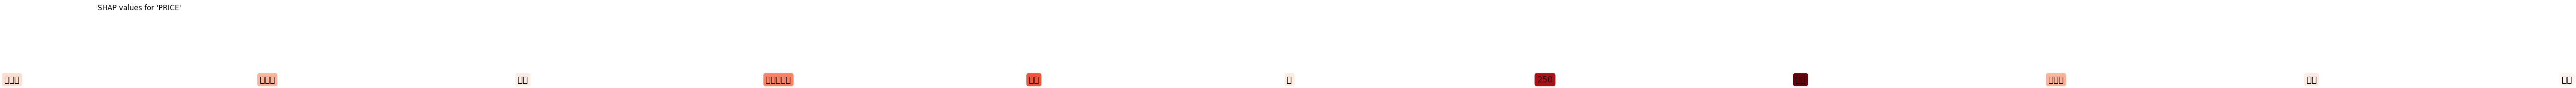

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_importances(tokens, importances, title="Token Importances"):
    plt.figure(figsize=(len(tokens)*0.7, 2))
    colors = plt.cm.Reds((np.array(importances) - min(importances)) / (max(importances) - min(importances) + 1e-8))
    for i, (token, imp) in enumerate(zip(tokens, importances)):
        plt.text(i, 0, token, fontsize=14, ha='center', va='center', 
                 bbox=dict(facecolor=colors[i], edgecolor='none', boxstyle='round,pad=0.3'))
    plt.axis('off')
    plt.title(title)
    plt.show()

# Example usage:
tokens = ["አዲስ", "አበባ", "ላይ", "የህጻናት", "ሻይ", "በ", "250", "ብር", "ሽያጭ", "ላይ", "ነው"]
importances = [0.1, 0.2, 0.05, 0.3, 0.4, 0.05, 0.6, 0.7, 0.2, 0.05, 0.01]  # Example SHAP/LIME values
plot_token_importances(tokens, importances, title="SHAP values for 'PRICE'")

In [5]:
from IPython.display import display, HTML

def color_tokens(tokens, importances, cmap='Reds'):
    norm = plt.Normalize(min(importances), max(importances))
    colors = plt.cm.get_cmap(cmap)
    html = ""
    for token, imp in zip(tokens, importances):
        color = colors(norm(imp))
        color_str = f"rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]:.2f})"
        html += f"<span style='background-color:{color_str}; padding:2px; margin:1px'>{token}</span> "
    display(HTML(html))

# Example usage:
color_tokens(tokens, importances)

C:\Users\Cyber Defense\AppData\Local\Temp\ipykernel_16660\2715236989.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)


## 4. LIME Explanations
Use LIME to generate local explanations for a sample prediction.

In [12]:
from lime.lime_text import LimeTextExplainer

def lime_predict_fn(texts):
    all_probs = []
    num_classes = len(predictor.label_list)
    for text in texts:
        probs, _ = predictor.predict_token_probs(text)
        # If no tokens, return zeros of correct shape
        if probs.ndim < 2 or probs.shape[0] == 0:
            all_probs.append(np.zeros(num_classes))
        else:
            all_probs.append(probs.mean(axis=0))
    return np.vstack(all_probs)

sample_text = "አዲስ አበባ ላይ የህጻናት ልብስ 250 ብር ሽያጭ ላይ ነው"

lime_explainer = LimeTextExplainer(class_names=predictor.label_list)
lime_exp = lime_explainer.explain_instance(
    sample_text,
    lime_predict_fn,
    num_features=10
)
lime_exp.show_in_notebook(text=True)


ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\IPython\core\display.py)

## 5. Analyze Difficult Cases
Select and interpret examples where the model struggles (e.g., ambiguous or misclassified entities).

In [13]:
# Example: Analyze a difficult sentence
difficult_text = 'በቦሌ ማእከል የሚገኙ አዲስ ምርቶች በ 5000 ብር ሽያጭ ላይ ናቸው'
shap_values_diff = explainer([difficult_text])
shap.plots.text(shap_values_diff[0])


ValueError: zero-size array to reduction operation maximum which has no identity

## 6. Reporting & Recommendations
Summarize findings, highlight model strengths/weaknesses, and suggest improvements.